In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib.patches import Patch

from scipy.optimize import curve_fit

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [15]:
conds = ['NL', '06hr','09hr','15hr','18hr', '21hr','24hr']
on_times = {'NL':0, '06hr':6,'09hr':9,'15hr':15,'18hr':18, '21hr':21,'24hr':24}

# Hidden variable model

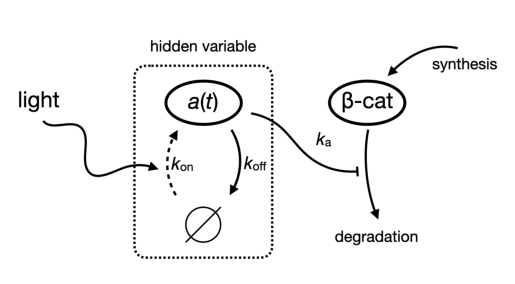

In [39]:
# Model schematic
img = plt.imread('./figures/Fig4A.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show() 

In [17]:
### ODE MODEL ###
def bcat_model(y, t, params, Wnt_function, Wnt_params):
    n = 2
    kon, koff, k1, k2, rmax, K = params
    a, bcat, tf = y
    dydt = [kon*(1 - a)*Wnt_function(t, Wnt_params) - (1-Wnt_function(t, Wnt_params))*koff*a, k1*(1 - bcat/(1+k2*a)), rmax*(bcat-1)**n/((bcat-1)**n + K**n)]
    return dydt

### STEADY STATE VALUES ###
def bcat_steady_state(params):
    # Calculates steady state values of model
    bcat0 = 1
    tf0 = 1
    a0 = 0
    return [a0, bcat0, tf0]

### WNT SIMULATION FUNCTIONS ###
def Wnt_duty_freq(t, params):
    # Light on/off function returning 1 or 0 based on frequency and duty cycle.
    # params = [frequency, duty_cycle]
    frequency, duty_cycle = params
    period = 1.0 / frequency
    if (t % period) < duty_cycle * period:
        return 1
    else:
        return 0

def Wnt_on_time(t, ontime):
    # Light on/off function returning 1 or 0 based on on-time.
    if t <= ontime:
        return 1
    else:
        return 0

In [18]:
### PARAMETERS ###

k1, k2,  = 0.2, 0.1
rmax, K = 6.5, 1
T = 48

t = np.linspace(0, T, 10000)
dt = t[1] - t[0]

# Quantifying concavity and minimum frequency

## Simulations

Code to run the simulations. Alternatively, import from ./hv_simulation/concavity.csv and ./hv_simulation/min_freq.csv. 

In [41]:
freqs = np.array([1/24, 1/16, 1/12, 1/8, 1/6, 1/4, 1/3, 1/2, 1, 2, 4, 8])

kons = np.linspace(0.1, 10, 56)
koffs = np.linspace(0.1, 10, 56)

X, Y = np.meshgrid(kons, koffs)

In [ ]:
# kon is on X axis, koff is on Y axis
concavity_out = np.zeros(len(koffs)*len(kons))
min_freq_out = np.zeros(len(koffs)*len(kons))

koff_out = np.zeros(0)
kon_out = np.zeros(0)

for i in np.arange(len(koffs)):
    koff_out = np.append(koff_out, koffs)

for i in np.arange(len(kons)):
    kon_out = np.append(kon_out, kons)

koff_out = np.sort(koff_out)

In [ ]:
def compute_properties(final_topflash):
    # Find the index of the local minimum
    min_index = np.argmin(final_topflash)
    
    # Check if the minimum is at the boundary
    if min_index == 0 or min_index == len(final_topflash) - 1:
        return 0, 0, 0
    
    quad_fit = np.polyfit(np.log(freqs[min_index-1:min_index+2]), final_topflash[min_index-1:min_index+2], 2)

    # Compute the concavity
    concavity = 2*quad_fit[0]

    # Compute minimum frequency
    min_freq = -quad_fit[1]/(2*quad_fit[0])

    return concavity, min_freq

In [ ]:
for i in np.arange(len(kon_out)):
    final_topflash = np.zeros(len(freqs))
    for j in np.arange(len(freqs)):
        # Solve ODE
        sol = odeint(bcat_model, [0,1,1], t, args=([kon_out[i], koff_out[i], k1, k2, rmax, K], Wnt_duty_freq, [freqs[j], 0.5]), tcrit =t)
        final_topflash[j] = sol[-1, -1]

    concavity_out[i], min_freq_out[i]  = compute_properties(final_topflash)

## Plots

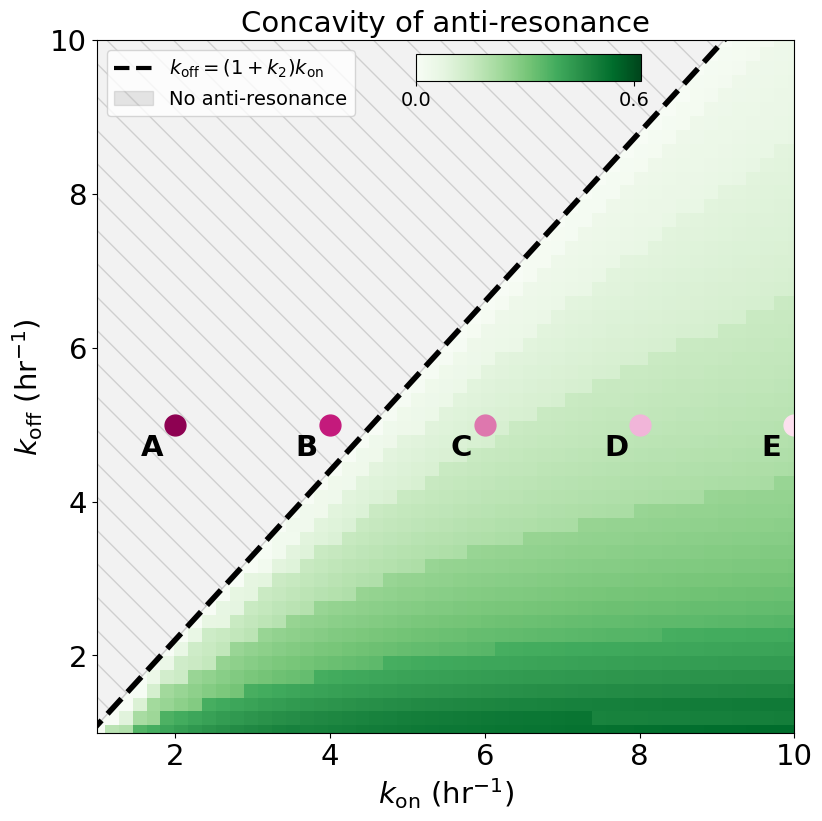

In [42]:
### PLOTTING CONCAVITY IN KON KOFF SPACE ###

fig, ax = plt.subplots(1, figsize=(9,9))

# Colormap for concavity_out below the transition line
concavity_out = np.genfromtxt('hv_simulation/concavity.csv', delimiter=',')

im = ax.pcolormesh(X, Y, 2*concavity_out.reshape(len(kons), len(koffs)), cmap='Greens')

ax.invert_yaxis()
ax.set_xlabel(r"$k_\text{on}$" + r"$\ (\text{hr}^{-1})$", fontsize=21)
ax.set_ylabel(r"$k_\text{off}$" + r"$\ (\text{hr}^{-1})$", fontsize=21)
ax.tick_params(labelsize=21)

# Colorbar
cb = fig.add_axes([0.48, 0.835, 0.25, 0.03])
color_bar = plt.colorbar(im, cax = cb, orientation = 'horizontal', ticks = [0, 0.6])
color_bar.ax.xaxis.set_tick_params(color='black')
color_bar.ax.tick_params(axis='x', colors='black', labelsize=14)

# Legend for existence of antiresonance
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', lw=3, label=r'$k_{\text{off}} = (1+k_2) k_{\text{on}}$'),
    Patch(facecolor='gray', edgecolor='gray', alpha=0.2, hatch='\\', label='No anti-resonance'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=14)

# Boundary line for existence of antiresonance
ax.plot(kons, koffs*(1+k2), color='black', linestyle='--', linewidth=4)

# Add red diagonal stripes to the "off-limits" region
x_vals = np.linspace(0, np.max(koffs), 100)
y_vals = x_vals * (1 + k2)

# Fill the region above the transition line with black
ax.fill_between(x_vals, y_vals, np.max(kons), color='white', alpha=1)
ax.fill_between(x_vals, y_vals, np.max(kons), color='gray', alpha=0.1)
ax.fill_between(x_vals, y_vals, np.max(kons), color='gray', alpha=0.3, hatch='\\', facecolor='none')

# Plot title
ax.set_title('Concavity of anti-resonance', fontsize=21)

# Axes limits
ax.set_xlim(0.99, np.max(kons))
ax.set_ylim(0.99, np.max(koffs))

colors = plt.colormaps['PiYG'](np.linspace(0, 0.4, 5))
x_nodes = [2, 4, 6, 8, 10]
y_nodes = [5, 5, 5, 5, 5]


for i in np.arange(len(x_nodes)):
    ax.plot(x_nodes[i], y_nodes[i], 'o', markersize=15, color=colors[i])
    ax.text(x_nodes[i]-0.3, y_nodes[i]-0.3, chr(65+i), color='black', fontweight='bold', fontsize=21, ha='center', va='center')
    
fig.savefig('./figures/Fig4B.pdf')

plt.show()

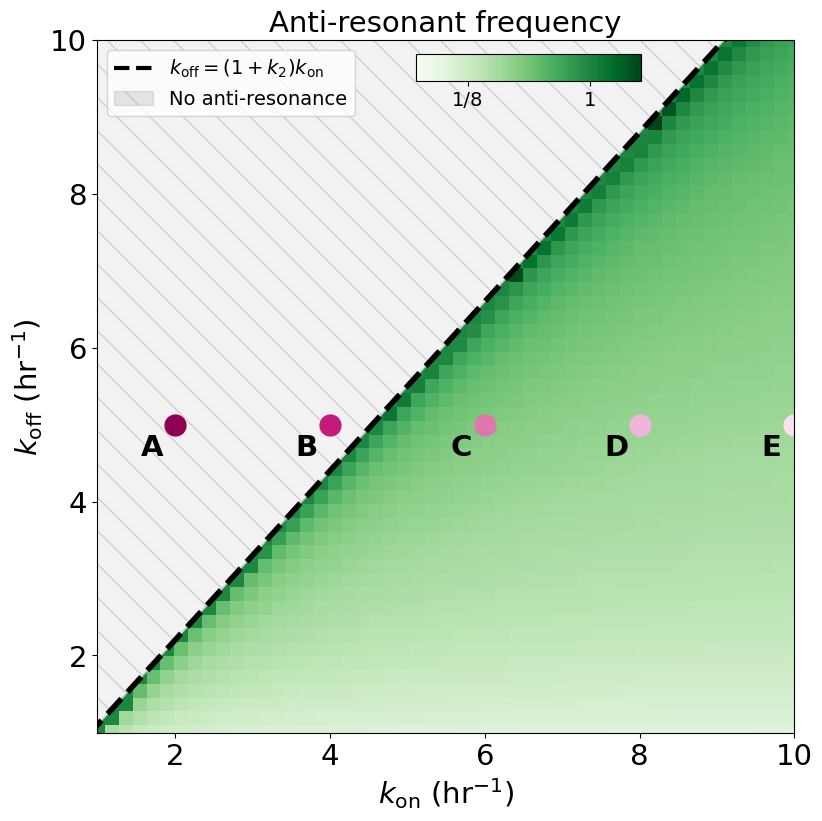

In [ ]:
### PLOTTING ANTIRESONANT FREQUENCY IN KON KOFF SPACE ### 

fig, ax = plt.subplots(1, figsize=(9,9))

# Colormap for concavity_out below the transition line
min_freq_out = np.genfromtxt('hv_simulation/min_freq.csv', delimiter=',')

im = ax.pcolormesh(X, Y, min_freq_out.reshape(len(kons), len(koffs)), cmap='Greens')

ax.invert_yaxis()
ax.set_xlabel(r"$k_\text{on}$" + r"$\ (\text{hr}^{-1})$", fontsize=21)
ax.set_ylabel(r"$k_\text{off}$" + r"$\ (\text{hr}^{-1})$", fontsize=21)
ax.tick_params(labelsize=21)

# Colorbar
cb = fig.add_axes([0.48, 0.835, 0.25, 0.03])
color_bar = plt.colorbar(im, cax = cb, orientation = 'horizontal', ticks = [np.log(0.125), np.log(1)])
color_bar.ax.set_xticklabels(['1/8', '1'])
color_bar.ax.xaxis.set_tick_params(color='black')
color_bar.ax.tick_params(axis='x', colors='black', labelsize=14)

# Legend for existence of antiresonance
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', lw=3, label=r'$k_{\text{off}} = (1+k_2) k_{\text{on}}$'),
    Patch(facecolor='gray', edgecolor='gray', alpha=0.2, hatch='\\', label='No anti-resonance'),
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=14)

# Boundary line for existence of antiresonance
ax.plot(kons, koffs*(1+k2), color='black', linestyle='--', linewidth=4)

# Add red diagonal stripes to the "off-limits" region
x_vals = np.linspace(0, np.max(koffs), 100)
y_vals = x_vals * (1 + k2)

# Fill the region above the transition line with black
ax.fill_between(x_vals, y_vals, np.max(kons), color='white', alpha=1)
ax.fill_between(x_vals, y_vals, np.max(kons), color='gray', alpha=0.1)
ax.fill_between(x_vals, y_vals, np.max(kons), color='gray', alpha=0.3, hatch='\\', facecolor='none')


# Plot title
ax.set_title('Anti-resonant frequency', fontsize=21)

# Axes limits
ax.set_xlim(0.99, np.max(kons))
ax.set_ylim(0.99, np.max(koffs))


# Add colored node at coordinate (2, 5) with the letter A under it
#colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
colors = plt.colormaps['PiYG'](np.linspace(0, 0.4, 5))
x_nodes = [2, 4, 6, 8, 10]
y_nodes = [5, 5, 5, 5, 5]


for i in np.arange(len(x_nodes)):
    ax.plot(x_nodes[i], y_nodes[i], 'o', markersize=15, color=colors[i])
    ax.text(x_nodes[i]-0.3, y_nodes[i]-0.3, chr(65+i), color='black', fontweight='bold', fontsize=21, ha='center', va='center')
    
fig.savefig('./figures/Fig4D.pdf')

plt.show()

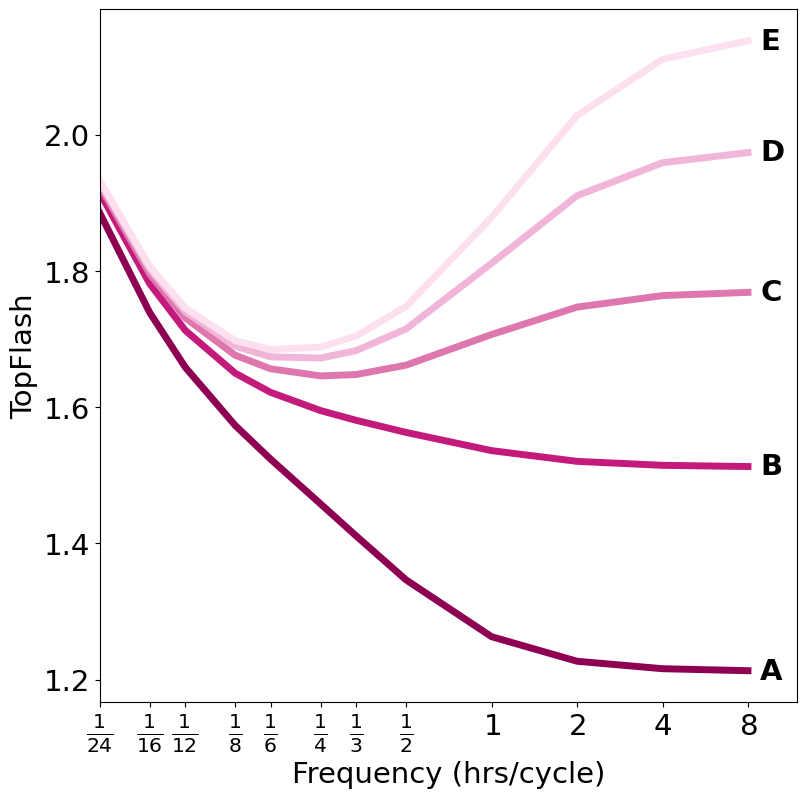

In [44]:
### PLOTTING CONSTANT DUTY CYCLE TRACES ###

fig, ax = plt.subplots(1, figsize=(9,9))

arr = np.linspace(2, 10, 5) # x values (the different kon values)

heights = np.zeros(len(arr)) # heights for labels
colors = plt.colormaps['PiYG'](np.linspace(0, 0.4, len(arr))) # colors for the curves

for i in np.arange(len(arr)):
    final_topflash = np.zeros(len(freqs))
    for j in np.arange(len(freqs)):
        # Solve ODE
        sol = odeint(bcat_model, [0,1,1], t, args=([arr[i], 5, k1, k2, rmax, K], Wnt_duty_freq, [freqs[j], 0.5]), tcrit =t)
        final_topflash[j] = sol[-1, -1]
    ax.plot(np.log(freqs), final_topflash, label = r"$k_{\text{on}} = $" + str(arr[i]) + r"$\text{ hr}^{-1}$", linewidth = 5, color = colors[i])
    heights[i] = final_topflash[-1]

ax.set_xlabel('Frequency (hrs/cycle)', fontsize=21)
ax.set_ylabel('TopFlash', fontsize=21)
ax.set_xticks(np.log(freqs),[r'$\frac{1}{24}$', r'$\frac{1}{16}$', r'$\frac{1}{12}$', r'$\frac{1}{8}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$', r'$8$']); 
ax.tick_params(labelsize=21)

ax.set_xlim(np.log(freqs[0]), np.log(freqs[-1])+0.4)

# Add labels to the curves
labels = ['A', 'B', 'C', 'D', 'E']

for i in range(len(arr)):
    ax.text(np.log(freqs[-1])+0.1, heights[i], labels[i], ha='left', va='center', fontweight = 'bold', fontsize=21)

fig.savefig('./figures/Fig4C.pdf')

plt.show()

# Exposure-time experiment and duty cycle frequency scan

The following figures appear in the supplemental text, to show that the hidden variable model is equally able to match the dynamics in the exposure-time experiment. 

In [32]:
conds = ['NL', '06hr','09hr','15hr','18hr', '21hr','24hr']
on_times = {'NL':0, '06hr':6,'09hr':9,'15hr':15,'18hr':18, '21hr':21,'24hr':24}
time = np.linspace(0,115/3,231)

In [33]:
data = {}
for cond in conds:
    data[cond] = {}
    data[cond]['TF'] = np.genfromtxt('./data/TF_'+cond+'.csv', delimiter=',')
    data[cond]['bcat'] = np.genfromtxt('./data/bcat_'+cond+'.csv', delimiter=',')

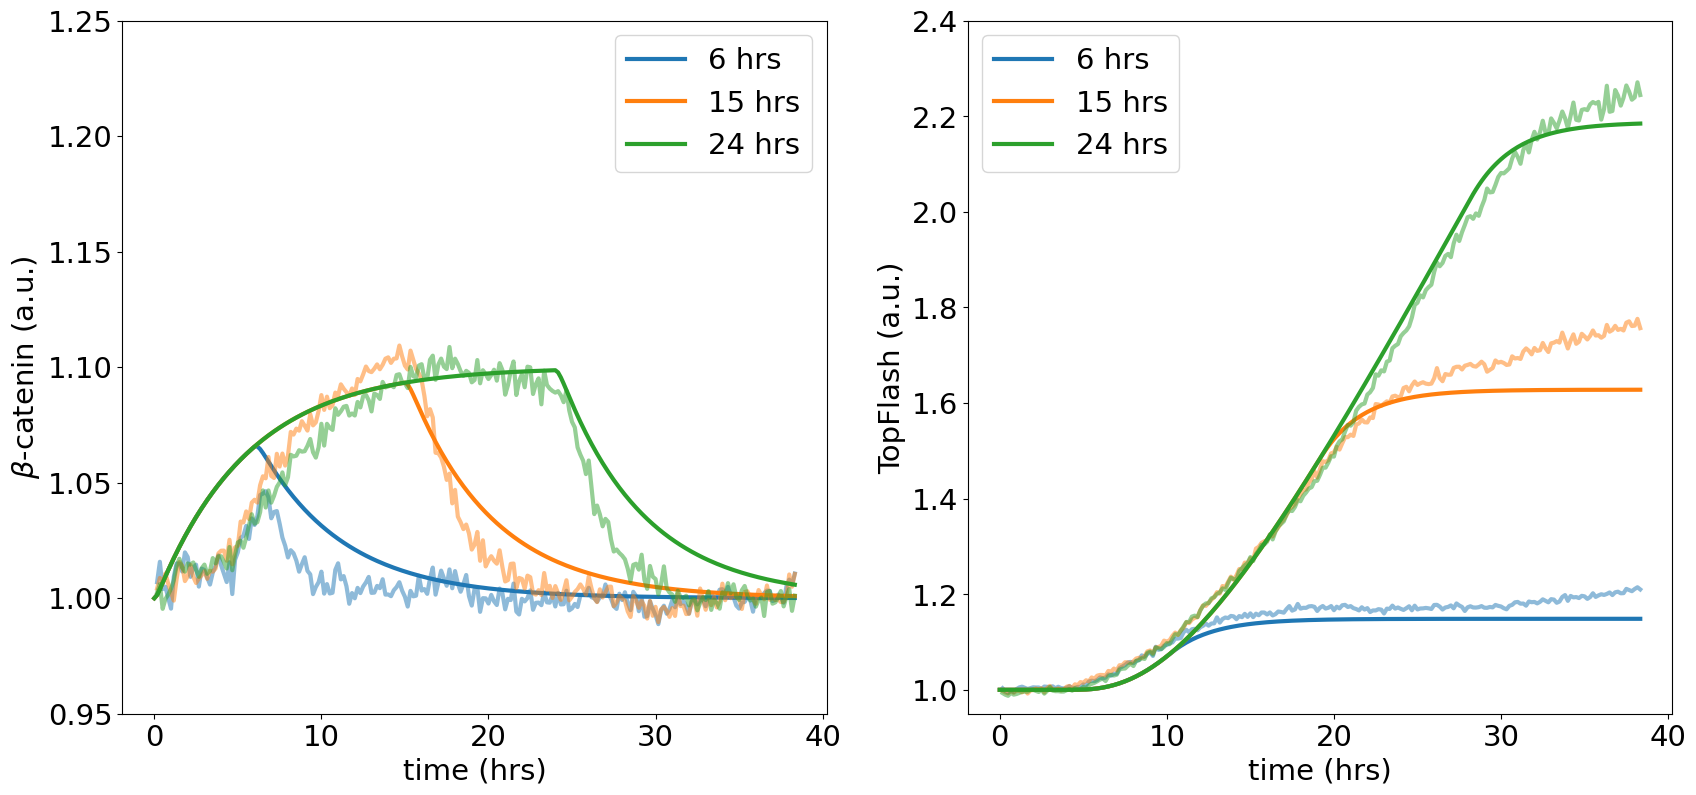

In [ ]:
### PLOTTING MODEL FIT TO EXPOSURE TIME EXPERIMENTS ###

sols = {}
for cond in ['NL','06hr','09hr', '15hr','18hr', '21hr', '24hr']:
    # Solve ODE
    sols[cond] = odeint(bcat_model, [0,1,1], time, args=([8, 5, k1, k2, rmax, K], Wnt_on_time, on_times[cond]))
    sols[cond][:, 2] = np.concatenate((np.ones(24), sols[cond][:, 2][:-24]))

# Plotting
labels = [r"$\beta$-cat", r"TopFlash"]
colors =  {'NL': 'tab:red', '06hr': 'tab:blue', '09hr': 'tab:cyan', '15hr':'tab:orange', '18hr':'tab:purple', '21hr':'tab:pink', '24hr':'tab:green'}

fig, axs = plt.subplots(1,2,figsize=(20,9)) #dpi=200)
for cond in ['06hr', '15hr','24hr']:
    for i in np.arange(len(labels)):
        if i == 0:
            axs[i].plot(time[1:], data[cond]['bcat'][1:], color = colors[cond], alpha = 0.5, linewidth=3)
        if i == 1:
            axs[i].plot(time[1:], data[cond]['TF'][1:], color = colors[cond], alpha = 0.5, linewidth=3)
        axs[i].plot(time, sols[cond][:, i+1], label=str(on_times[cond]) + ' hrs', linewidth=3, color=colors[cond])
        axs[i].set_xlabel('time (hrs)', fontsize=21)
        axs[i].legend(fontsize=21)
        axs[i].tick_params(labelsize=21)
    axs[0].set_ylabel(r"$\beta$-catenin (a.u.)", fontsize=21)
    axs[1].set_ylabel(r"TopFlash (a.u.)", fontsize=21)
    axs[0].set_ylim((0.95,1.25))
    axs[1].set_ylim((0.95,2.4))

In [36]:
freqs = np.array([1/48, 1/24, 1/16, 1/12, 1/8, 1/6, 1/4, 1/3, 1/2, 1, 2, 4, 8])
duty_cycles = np.array([0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [37]:
# Experiment duration
T = 48

# Time vector
t = np.linspace(0, T, 10000)
dt = t[1]-t[0]

topflash_out = np.zeros(len(freqs)*len(duty_cycles))
bcat_out = np.zeros(len(freqs)*len(duty_cycles))

topflash_int = np.zeros(len(freqs)*len(duty_cycles))
bcat_int = np.zeros(len(freqs)*len(duty_cycles))

freq_out = np.zeros(0)
duty_cycle_out = np.zeros(0)
for i in np.arange(len(duty_cycles)):
    freq_out = np.append(freq_out, freqs)
for i in np.arange(len(freqs)):
    duty_cycle_out = np.append(duty_cycle_out, duty_cycles)
duty_cycle_out = np.sort(duty_cycle_out)

for i in np.arange(len(freq_out)):
    # Solve ODE
    sol = odeint(bcat_model, [0,1,1], t, args=([8, 5, k1, k2, rmax, K], Wnt_duty_freq, [freq_out[i], duty_cycle_out[i]]), tcrit =t)
    topflash_out[i] = sol[-1, 2]

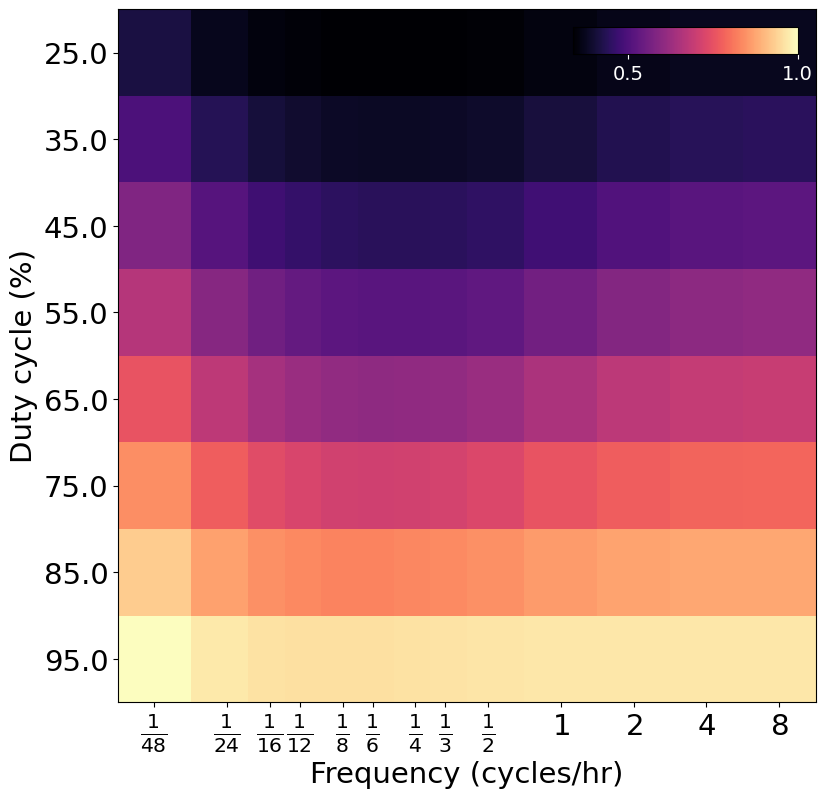

In [38]:
### PLOTTING TOPFLASH HEATMAP ###

x_values = np.log(freqs)
y_values = duty_cycles
color_values = topflash_out / np.max(topflash_out)

X, Y = np.meshgrid(x_values, y_values)

fig, ax = plt.subplots(1, figsize=(9,9))
im = ax.pcolormesh(X, Y, color_values.reshape(len(duty_cycles),len(freqs)), cmap='magma') #,shading='gouraud'


ax.set_xlabel(r"Frequency (cycles/hr)", fontsize=21)
ax.set_ylabel(r"Duty cycle (%)", fontsize=21)
ax.set_xticks(np.log([1/48, 1/24,1/16,1/12,1/8,1/6,1/4,1/3,1/2,1,2,4,8]),[r'$\frac{1}{48}$', r'$\frac{1}{24}$', r'$\frac{1}{16}$', r'$\frac{1}{12}$', r'$\frac{1}{8}$', r'$\frac{1}{6}$', r'$\frac{1}{4}$', r'$\frac{1}{3}$', r'$\frac{1}{2}$', r'$1$', r'$2$', r'$4$', r'$8$']); 
ax.set_yticks(duty_cycles, np.round(np.array(duty_cycles)*100,0)); 
ax.tick_params(labelsize=21)
ax.invert_yaxis()

cb = fig.add_axes([0.63, 0.83, 0.25, 0.03])
color_bar = plt.colorbar(im, cax = cb, orientation = 'horizontal', ticks = [0.5, 1])

color_bar.ax.xaxis.set_tick_params(color='white')
color_bar.ax.tick_params(axis='x', colors='white', labelsize=14)
